# Getting Started
First, we import the libraries we will be using to manipulate our time-series data.

## Import Libraries and Data

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

 Let's look at the `aranet4` and `aranetExp` data. We have 3 objects with Date and Time labels, but their object type isn't set.

In [24]:
# Load the data from the CSV file
aranet4 = pd.read_csv('../datasets/aranet4.csv')
aranetExp = pd.read_csv('../datasets/aranetExp.csv')
aranet4.info(), aranetExp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125216 entries, 0 to 125215
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Datetime                   125216 non-null  object 
 1   Carbon dioxide(ppm)        125216 non-null  int64  
 2   Temperature(°F)            125216 non-null  float64
 3   Relative humidity(%)       125163 non-null  float64
 4   Atmospheric pressure(hPa)  122694 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 4.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             190 non-null    int64 
 1   date           190 non-null    object
 2   time           190 non-null    object
 3   door1          190 non-null    object
 4   door2          190 non-null    object
 5   hvac           190 

(None, None)

Let's set the date time objects

Set the `DatetimeIndex` for `aranetExp` and drop non-Feature columns. `id` is a SQL record tracking column, we do not need it.

In [25]:
aranetExp['date'] = pd.to_datetime(aranetExp['date'])
aranetExp = aranetExp.rename(columns={'date': 'Datetime'})
aranetExp = aranetExp.drop(columns=['id','time'])
aranetExp = aranetExp.set_index('Datetime')
aranetExp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 190 entries, 2024-03-13 13:04:41 to 2024-04-08 13:18:01
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   door1          190 non-null    object
 1   door2          190 non-null    object
 2   hvac           190 non-null    object
 3   subject_count  190 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 7.4+ KB


In [26]:
aranet4['Datetime'] = pd.to_datetime(aranet4['Datetime'])
aranet4 = aranet4.set_index('Datetime')
aranet4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 125216 entries, 2024-01-12 16:08:15 to 2024-04-08 16:03:11
Data columns (total 4 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Carbon dioxide(ppm)        125216 non-null  int64  
 1   Temperature(°F)            125216 non-null  float64
 2   Relative humidity(%)       125163 non-null  float64
 3   Atmospheric pressure(hPa)  122694 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 4.8 MB


We see the `DatetimeIndex` now has the format and domain of our datetime column. Additionally, given our index has seconds as it's record keeper, we should be able to join the aranetExp data by weaving the records (creating nulls in the left or right dataset depending on what is missing) and then use filling methods.

To merge two time series datasets based on the nearest timestamp, you can use the `merge_asof` function from pandas. This function will merge the two datasets based on the closest timestamp, rather than an exact match.

Here's how you can use it:



This merge didn't exactly capture what we intended, some records appear to have been doubly assigned when merging on aranet4 from aranetExp. It wouldn't be the worst outcome if merged aranetExp records to the first matching record and if there is a conflict with the proceding one to shift it to the next record an so forth, given the aranetExp records are so sparse. Very few values would risk be shifted from their original record. Further, a match merge under the following routine would also use to drop the `seconds` time hold and look specifically at the minutes.

Given the design of our experiment, it might be wiser to first resample and reindex the aranetExp data to how we want it and then join the aranet4 sensor data to it. Regardless, data should be prepared for seemless merging.

## Joining Two Time-series Dataframes on a common index

Let's start with the `aranetExp` data. 

In [27]:
# Create a copy of aranetExp
aranetExp_copy = aranetExp.copy()

# Round the 'Datetime' index to the nearest minute
aranetExp_copy.index = aranetExp_copy.index.round('min')
# Ensure each record has a unique datetime to the minute
unique_minutes = set()
for i in range(len(aranetExp_copy)):
    current_time = aranetExp_copy.index[i]
    original_time = current_time
    while current_time in unique_minutes:
        print(f"Changing {current_time} to ", end="")
        current_time += pd.Timedelta(minutes=1)
        print(f"{current_time}")
    if current_time != original_time:
        print(f"Original time {original_time} changed to {current_time}")
    unique_minutes.add(current_time)
    aranetExp_copy.index.values[i] = current_time

aranetExp_copy.info()

Changing 2024-03-13 13:08:00 to 2024-03-13 13:09:00
Original time 2024-03-13 13:08:00 changed to 2024-03-13 13:09:00
Changing 2024-03-18 12:25:00 to 2024-03-18 12:26:00
Original time 2024-03-18 12:25:00 changed to 2024-03-18 12:26:00
Changing 2024-03-18 12:26:00 to 2024-03-18 12:27:00
Original time 2024-03-18 12:26:00 changed to 2024-03-18 12:27:00
Changing 2024-03-19 09:18:00 to 2024-03-19 09:19:00
Original time 2024-03-19 09:18:00 changed to 2024-03-19 09:19:00
Changing 2024-03-25 10:18:00 to 2024-03-25 10:19:00
Original time 2024-03-25 10:18:00 changed to 2024-03-25 10:19:00
Changing 2024-04-02 12:34:00 to 2024-04-02 12:35:00
Original time 2024-04-02 12:34:00 changed to 2024-04-02 12:35:00
Changing 2024-04-04 12:30:00 to 2024-04-04 12:31:00
Original time 2024-04-04 12:30:00 changed to 2024-04-04 12:31:00
Changing 2024-04-08 12:31:00 to 2024-04-08 12:32:00
Original time 2024-04-08 12:31:00 changed to 2024-04-08 12:32:00
Changing 2024-04-08 12:32:00 to 2024-04-08 12:33:00
Original tim

So, we had a few minutes that needed to pushed, that is okay because we tracked them. Likewise, it is explainable why they were so clustered, the records occur near the start and end of lecture, so the observer was tracking subject_count records changing quickly due to people arriving and leaving lecture. We can confirm these later.

Now, let's round the minutes in the aranet4 sensor data.

In [28]:
def custom_round_to_nearest_minute(dt_index):
    rounded_index = dt_index.floor('min') + pd.to_timedelta((dt_index.second >= 30).astype(int), unit='min')
    rounded_index.name = dt_index.name  # Preserve the name of the index
    return rounded_index

# Create a copy of aranet4
aranet4_copy = aranet4.copy()

# Use the custom function to round the 'Datetime' index to the nearest minute
aranet4_copy.index = custom_round_to_nearest_minute(aranet4_copy.index)

# Display the updated DataFrame info
aranet4_copy.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 125216 entries, 2024-01-12 16:08:00 to 2024-04-08 16:03:00
Data columns (total 4 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Carbon dioxide(ppm)        125216 non-null  int64  
 1   Temperature(°F)            125216 non-null  float64
 2   Relative humidity(%)       125163 non-null  float64
 3   Atmospheric pressure(hPa)  122694 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 4.8 MB


We see all records in both the sensor and experiment data sets round to the nearest minute. Let's try merging again onto aranet4 and see if we get the correct number of records.

In [29]:
# Merge aranet4_copy with aranetExp_copy using an exact match on the 'Datetime' index
merged = pd.merge(aranet4_copy, aranetExp_copy, left_on='Datetime', right_index=True, how='left')

# Display the info of the merged DataFrame
merged.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 125216 entries, 2024-01-12 16:08:00 to 2024-04-08 16:03:00
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Carbon dioxide(ppm)        125216 non-null  int64  
 1   Temperature(°F)            125216 non-null  float64
 2   Relative humidity(%)       125163 non-null  float64
 3   Atmospheric pressure(hPa)  122694 non-null  float64
 4   door1                      190 non-null     object 
 5   door2                      190 non-null     object 
 6   hvac                       190 non-null     object 
 7   subject_count              190 non-null     float64
dtypes: float64(4), int64(1), object(3)
memory usage: 8.6+ MB


Much better! We might be missing 1 record from aranetExp

## Sensor Features
Guess. Normalize all the features, seeing them on a normalized scale might help use visualize the possible signifance if the features in predicting one another. Compare with correlations.

## Creating Time Features

In [30]:
# aranet4['month'] = aranet4.index.month
# aranet4['day_of_month'] = aranet4.index.day

aranet_tf = merged.copy()
aranet_tf['hour'] = aranet_tf.index.hour
aranet_tf['minute'] = aranet_tf.index.minute

aranet_tf['day_of_week'] = aranet_tf.index.dayofweek
aranet_tf['weekday'] = aranet_tf.index.day_name()
# aranet4['week_of_year'] =aranet4.index.weekofyear


aranet_tf.head()

,Carbon dioxide(ppm),Temperature(°F),Relative humidity(%),Atmospheric pressure(hPa),door1,door2,hvac,subject_count,hour,minute,day_of_week,weekday
Datetime,,,,,,,,,,,,
2024-01-12 16:08:00,1014,77.8,47.0,1007.3,NaN,NaN,NaN,NaN,16,8,4,Friday
2024-01-12 16:09:00,884,78.5,46.0,1007.3,NaN,NaN,NaN,NaN,16,9,4,Friday
2024-01-12 16:10:00,914,79.7,43.0,1007.4,NaN,NaN,NaN,NaN,16,10,4,Friday
2024-01-12 16:11:00,906,79.7,42.0,1007.2,NaN,NaN,NaN,NaN,16,11,4,Friday
2024-01-12 16:12:00,896,79.3,41.0,1007.3,NaN,NaN,NaN,NaN,16,12,4,Friday


## Upsampling, Downsampling, `.resample()`

We will typically only using downsampling when dealing with the Aranet4 dataset. This means using `resample()` or `reindex()` methods with some form of aggregation to go from minute to minute records to say 5, 10, 15, 30, 60, or some other period for our records.

We will need some form of upsampling when working with the AranetExp data. The data will have to be indexed, properly joined, and filled.

# Aranet Subsetting Methods



In [31]:
aranet = aranet_tf.copy()

# Filter the DataFrame to include all records from "2024-03-14 00:00:00" onwards
aranet_filtered = aranet.loc["2024-03-14 00:00:00":]

# Display the first 10 records of the filtered DataFrame
aranet_filtered.head(10)


,Carbon dioxide(ppm),Temperature(°F),Relative humidity(%),Atmospheric pressure(hPa),door1,door2,hvac,subject_count,hour,minute,day_of_week,weekday
Datetime,,,,,,,,,,,,
2024-03-14 00:00:00,916,75.9,39.0,1014.6,NaN,NaN,NaN,NaN,0,0,3,Thursday
2024-03-14 00:01:00,914,76.0,39.0,1014.6,NaN,NaN,NaN,NaN,0,1,3,Thursday
2024-03-14 00:02:00,920,75.9,39.0,1014.6,NaN,NaN,NaN,NaN,0,2,3,Thursday
2024-03-14 00:03:00,918,75.9,39.0,1014.5,NaN,NaN,NaN,NaN,0,3,3,Thursday
2024-03-14 00:04:00,901,75.9,39.0,1014.5,NaN,NaN,NaN,NaN,0,4,3,Thursday
2024-03-14 00:05:00,917,76.0,39.0,1014.5,NaN,NaN,NaN,NaN,0,5,3,Thursday
2024-03-14 00:06:00,920,75.9,39.0,1014.6,NaN,NaN,NaN,NaN,0,6,3,Thursday
2024-03-14 00:07:00,921,75.9,39.0,1014.5,NaN,NaN,NaN,NaN,0,7,3,Thursday
2024-03-14 00:08:00,898,75.9,39.0,1014.6,NaN,NaN,NaN,NaN,0,8,3,Thursday


In [32]:
# Define a function to label the time periods as a boolean
def label_song_lec(row):
    if row.name.dayofweek in [0, 1, 2, 3]:  # Monday to Thursday
        if row.name.time() >= pd.to_datetime('12:15').time() and row.name.time() <= pd.to_datetime('13:30').time():
            return True
    return False

# Apply the function to the DataFrame
aranet_filtered['song_lec'] = aranet_filtered.apply(label_song_lec, axis=1)

def label_chen_lec(row):
    if row.name.dayofweek in [0, 2]:  # Monday and Wednesday
        if row.name.time() >= pd.to_datetime('09:00').time() and row.name.time() <= pd.to_datetime('10:15').time():
            return True
    elif row.name.dayofweek in [1, 3]:  # Tuesday and Thursday
        if row.name.time() >= pd.to_datetime('08:00').time() and row.name.time() <= pd.to_datetime('09:15').time():
            return True
    return False

aranet_filtered['chen_lec'] = aranet_filtered.apply(label_chen_lec, axis=1)

# Check the first few rows to verify the new feature
aranet_filtered.head()


C:\Users\Corey Dearing\AppData\Local\Temp\ipykernel_70788\352536041.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aranet_filtered['song_lec'] = aranet_filtered.apply(label_song_lec, axis=1)
C:\Users\Corey Dearing\AppData\Local\Temp\ipykernel_70788\352536041.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aranet_filtered['chen_lec'] = aranet_filtered.apply(label_chen_lec, axis=1)


,Carbon dioxide(ppm),Temperature(°F),Relative humidity(%),Atmospheric pressure(hPa),door1,door2,hvac,subject_count,hour,minute,day_of_week,weekday,song_lec,chen_lec
Datetime,,,,,,,,,,,,,,
2024-03-14 00:00:00,916,75.9,39.0,1014.6,NaN,NaN,NaN,NaN,0,0,3,Thursday,False,False
2024-03-14 00:01:00,914,76.0,39.0,1014.6,NaN,NaN,NaN,NaN,0,1,3,Thursday,False,False
2024-03-14 00:02:00,920,75.9,39.0,1014.6,NaN,NaN,NaN,NaN,0,2,3,Thursday,False,False
2024-03-14 00:03:00,918,75.9,39.0,1014.5,NaN,NaN,NaN,NaN,0,3,3,Thursday,False,False
2024-03-14 00:04:00,901,75.9,39.0,1014.5,NaN,NaN,NaN,NaN,0,4,3,Thursday,False,False


In [33]:
filtered_lec_df = aranet_filtered[(aranet_filtered['song_lec'] == True) | (aranet_filtered['chen_lec'] == True)]
filtered_lec_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2126 entries, 2024-03-14 08:00:00 to 2024-04-08 13:30:00
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Carbon dioxide(ppm)        2126 non-null   int64  
 1   Temperature(°F)            2126 non-null   float64
 2   Relative humidity(%)       2126 non-null   float64
 3   Atmospheric pressure(hPa)  2126 non-null   float64
 4   door1                      160 non-null    object 
 5   door2                      160 non-null    object 
 6   hvac                       160 non-null    object 
 7   subject_count              160 non-null    float64
 8   hour                       2126 non-null   int64  
 9   minute                     2126 non-null   int64  
 10  day_of_week                2126 non-null   int64  
 11  weekday                    2126 non-null   object 
 12  song_lec                   2126 non-null   bool   
 13  chen_lec    

Next, we can fill the nans for each lecture, normalize the data, flatten each sample into a one dimensional array and label it based upon the experiments initial conditions. The flattened merged flattened arrays will be (feature,minute) record of one lecture to the (feature,minute) record of another lecture. A record from the data set is all the values of a particular (feature, minute) slice. So a box plot of co2 at 30 minutes would be a record containing the set of all lecture values corresponding to co2 and 30 minutes.


We can upsample lecture cases with small counts if needed. Then we will combine the one dimensional arrays to build a predictor/classifer for whether or not co2 will rise or fall by a certain amount. 

Can we flatten each sample without losing to much information? Perhaps.

What happens if we reset the index and plot the slices back to back? And Plot it.

In [34]:
# Check if the specific minute is missing in filtered_lec_df
missing_time = '2024-03-26 08:43:00'
if missing_time in aranet.index:
    print(f"The record for {missing_time} is present in filtered_lec_df.")
else:
    print(f"The record for {missing_time} is missing in filtered_lec_df.")


The record for 2024-03-26 08:43:00 is missing in filtered_lec_df.


In [35]:
# Sort the DataFrame by index (datetime)
# filtered_lec_df = filtered_lec_df.sort_index()

# Initialize variables
sliced_dataframes = {}
lecture_start_time = None
lecture_type = None
lecture_count = {'song': 0, 'chen': 0}

# Iterate through the DataFrame
for index, row in filtered_lec_df.iterrows():
    # Check if we are in a new lecture
    if lecture_start_time is None or (index - lecture_start_time).total_seconds() > 75 * 60 or (row['song_lec'] and lecture_type != 'song') or (row['chen_lec'] and lecture_type != 'chen'):
        # Store the previous lecture if it exists
        if lecture_start_time is not None:
            lecture_label = f"{lecture_type}_lec_{lecture_count[lecture_type]}"
            # Subtract one minute from the end index of the slice
            sliced_dataframes[lecture_label] = filtered_lec_df.loc[lecture_start_time:index - pd.Timedelta(minutes=1)]
        
        # Update the lecture start time and type
        lecture_start_time = index
        if row['song_lec']:
            lecture_type = 'song'
        elif row['chen_lec']:
            lecture_type = 'chen'
        lecture_count[lecture_type] += 1

# Store the last lecture
if lecture_start_time is not None:
    lecture_label = f"{lecture_type}_lec_{lecture_count[lecture_type]}"
    # Subtract one minute from the end index of the last slice
    sliced_dataframes[lecture_label] = filtered_lec_df.loc[lecture_start_time:index - pd.Timedelta(minutes=1)]

# Display the keys of the sliced dataframes
print(sliced_dataframes.keys())


# Impute missing values in each lecture slice
# Iterate over each key (lecture) in the dictionary
for lecture_key in sliced_dataframes.keys():
    # Forward fill to impute missing values
    sliced_dataframes[lecture_key] = sliced_dataframes[lecture_key].ffill()

    # Backward fill to impute remaining missing values
    sliced_dataframes[lecture_key] = sliced_dataframes[lecture_key].bfill()



# Check if any column in the DataFrame has 0 non-null values

# Copy the keys to a list to avoid RuntimeError for changing dict size during iteration
keys_to_check = list(sliced_dataframes.keys())

# Store the lectures that will be removed
removed_lectures = []

for lecture_key in keys_to_check:
    # Check if any column in the DataFrame has 0 non-null values
    if (sliced_dataframes[lecture_key].count() == 0).any():
        # If found, add to the list of lectures to remove and delete from dictionary
        removed_lectures.append(lecture_key)
        del sliced_dataframes[lecture_key]

# Print the lectures that were removed
print("Lectures removed due to 0 non-null counts in all columns:", removed_lectures)

# Define a function to fill missing minutes in the DataFrame
def fill_missing_minutes_in_lectures(sliced_dataframes):
    for lecture_key, df in sliced_dataframes.items():
        # Get the minute column as a Series
        minutes = df.index.minute
        
        # Find the difference between consecutive minutes
        minute_diffs = minutes.to_series().diff().fillna(1)  # Fill the first NaN with 1
        
        # Identify indices where the difference is greater than 1
        missing_minute_indices = minute_diffs[minute_diffs > 1].index
        
        # For each missing minute, add a new row with NaN values
        for idx in missing_minute_indices:
            missing_time = df.index[idx - 1] + pd.Timedelta(minutes=1)
            empty_row = pd.DataFrame({col: np.nan for col in df.columns}, index=[missing_time])
            df = pd.concat([df, empty_row])
            print(f"Empty record created for {lecture_key} at {missing_time}")
        
        # Sort the DataFrame after adding new rows to maintain chronological order
        sliced_dataframes[lecture_key] = df.sort_index()
        
    return sliced_dataframes

# Apply the function
sliced_dataframes = fill_missing_minutes_in_lectures(sliced_dataframes)

def ensure_song_lecture_endpoints(sliced_dataframes):
    for lecture_key, df in sliced_dataframes.items():
        if 'song_lec' in lecture_key:
            # Check if the start and end points are missing
            start_time = df.index.min().replace(hour=12, minute=15, second=0)
            end_time = df.index.max().replace(hour=13, minute=30, second=0)

            if df.index.min() != start_time:
                # Add a new row at the start time with NaN values
                df.loc[start_time] = [np.nan] * len(df.columns)
                print(f"Start record created for {lecture_key} at {start_time}")

            if df.index.max() != end_time:
                # Add a new row at the end time with NaN values
                df.loc[end_time] = [np.nan] * len(df.columns)
                print(f"End record created for {lecture_key} at {end_time}")

            # Sort the DataFrame after adding new rows to maintain chronological order
            sliced_dataframes[lecture_key] = df.sort_index()

    return sliced_dataframes

# Apply the function
sliced_dataframes = ensure_song_lecture_endpoints(sliced_dataframes)

# Impute missing values in each lecture slice
# Iterate over each key (lecture) in the dictionary
for lecture_key in sliced_dataframes.keys():
    # Forward fill to impute missing values
    sliced_dataframes[lecture_key] = sliced_dataframes[lecture_key].ffill()

    # Backward fill to impute remaining missing values
    sliced_dataframes[lecture_key] = sliced_dataframes[lecture_key].bfill()


dict_keys(['chen_lec_1', 'song_lec_1', 'chen_lec_2', 'song_lec_2', 'chen_lec_3', 'song_lec_3', 'chen_lec_4', 'song_lec_4', 'chen_lec_5', 'song_lec_5', 'chen_lec_6', 'song_lec_6', 'chen_lec_7', 'song_lec_7', 'chen_lec_8', 'song_lec_8', 'chen_lec_9', 'song_lec_9', 'chen_lec_10', 'song_lec_10', 'chen_lec_11', 'song_lec_11', 'chen_lec_12', 'song_lec_12', 'chen_lec_13', 'song_lec_13', 'chen_lec_14', 'song_lec_14'])
Lectures removed due to 0 non-null counts in all columns: ['chen_lec_5', 'song_lec_5', 'chen_lec_8', 'song_lec_8', 'chen_lec_9', 'song_lec_9', 'song_lec_10', 'chen_lec_11']
Empty record created for chen_lec_7 at 2024-03-26 08:45:00
End record created for song_lec_14 at 2024-04-08 13:30:00


C:\Users\Corey Dearing\AppData\Local\Temp\ipykernel_70788\3715743538.py:83: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([df, empty_row])
C:\Users\Corey Dearing\AppData\Local\Temp\ipykernel_70788\3715743538.py:108: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[end_time] = [np.nan] * len(df.columns)


In [36]:
# Print the length of the flattened arrays for each lecture
for lecture_key, df in sliced_dataframes.items():
    print(f"{lecture_key}: {len(df.values.flatten())}")


chen_lec_1: 1064
song_lec_1: 1064
chen_lec_2: 1064
song_lec_2: 1064
chen_lec_3: 1064
song_lec_3: 1064
chen_lec_4: 1064
song_lec_4: 1064
chen_lec_6: 1064
song_lec_6: 1064
chen_lec_7: 1064
song_lec_7: 1064
chen_lec_10: 1064
song_lec_11: 1064
chen_lec_12: 1064
song_lec_12: 1064
chen_lec_13: 1064
song_lec_13: 1064
chen_lec_14: 1064
song_lec_14: 1064


Flatten each lecture and concatenate row wise. We should expect the output to have a lot of `NaN` values because they were not addressed. Also we need to dummy encode and regularize/normalize our numeric features pre slicing and flattening. But for now, it is easier to read the structure of what we have done with the data as is.

**Note:** Apparently this might be called `windowing` the sequenced data to create samples for training.

In [37]:
# Flatten each lecture DataFrame into a one-dimensional array
flattened_lectures = [df.values.flatten() for df in sliced_dataframes.values()]

# Create a new DataFrame from the flattened arrays
flattened_df = pd.DataFrame(flattened_lectures)

flattened_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 1064 entries, 0 to 1063
dtypes: float64(608), object(456)
memory usage: 166.4+ KB


In [38]:

# Transpose the DataFrame so that each lecture is a column
transposed_df = flattened_df.T

# Optionally, you can add lecture labels as column names
transposed_df.columns = sliced_dataframes.keys()

# Display the resulting DataFrame
transposed_df.head(30)



,chen_lec_1,song_lec_1,chen_lec_2,song_lec_2,chen_lec_3,song_lec_3,chen_lec_4,song_lec_4,chen_lec_6,song_lec_6,chen_lec_7,song_lec_7,chen_lec_10,song_lec_11,chen_lec_12,song_lec_12,chen_lec_13,song_lec_13,chen_lec_14,song_lec_14
0,595.0,773.0,596.0,543.0,627.0,1035.0,634.0,949.0,617.0,947.0,781.0,943.0,593.0,460.0,578.0,958.0,649.0,1138.0,687.0,1001.0
1,65.8,74.5,70.7,76.0,58.5,68.4,64.2,71.7,61.2,73.8,68.8,66.4,72.4,84.7,71.5,71.6,67.4,69.6,69.9,75.2
2,40.0,37.0,46.0,37.0,41.0,32.0,34.0,29.0,43.0,32.0,42.0,39.0,46.0,50.0,59.0,47.0,45.0,43.0,40.0,36.0
3,1017.0,1018.1,1007.1,1007.4,1015.9,1016.5,1012.7,1012.3,1023.1,1023.0,1019.1,1018.9,1013.4,1009.2,999.0,997.9,1000.3,1000.6,1022.3,1022.2
4,open,open,open,open,open,open,open,open,open,open,open,open,open,open,open,open,open,open,open,open
5,open,open,open,closed,closed,open,open,closed,open,open,open,open,open,open,closed,open,open,open,closed,closed
6,on,off,off,on,off,off,off,off,off,off,on,off,off,off,on,on,off,on,off,on
7,10.0,3.0,16.0,2.0,13.0,14.0,13.0,15.0,15.0,10.0,18.0,19.0,15.0,3.0,14.0,17.0,14.0,15.0,15.0,5.0
8,8.0,12.0,9.0,12.0,8.0,12.0,9.0,12.0,9.0,12.0,8.0,12.0,9.0,12.0,9.0,12.0,8.0,12.0,9.0,12.0
9,0.0,15.0,0.0,15.0,0.0,15.0,0.0,15.0,0.0,15.0,0.0,15.0,0.0,15.0,0.0,15.0,0.0,15.0,0.0,15.0


In [39]:
transposed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064 entries, 0 to 1063
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   chen_lec_1   1064 non-null   object
 1   song_lec_1   1064 non-null   object
 2   chen_lec_2   1064 non-null   object
 3   song_lec_2   1064 non-null   object
 4   chen_lec_3   1064 non-null   object
 5   song_lec_3   1064 non-null   object
 6   chen_lec_4   1064 non-null   object
 7   song_lec_4   1064 non-null   object
 8   chen_lec_6   1064 non-null   object
 9   song_lec_6   1064 non-null   object
 10  chen_lec_7   1064 non-null   object
 11  song_lec_7   1064 non-null   object
 12  chen_lec_10  1064 non-null   object
 13  song_lec_11  1064 non-null   object
 14  chen_lec_12  1064 non-null   object
 15  song_lec_12  1064 non-null   object
 16  chen_lec_13  1064 non-null   object
 17  song_lec_13  1064 non-null   object
 18  chen_lec_14  1064 non-null   object
 19  song_lec_14  1064 non-null 

In [40]:
transposed_df.head()

,chen_lec_1,song_lec_1,chen_lec_2,song_lec_2,chen_lec_3,song_lec_3,chen_lec_4,song_lec_4,chen_lec_6,song_lec_6,chen_lec_7,song_lec_7,chen_lec_10,song_lec_11,chen_lec_12,song_lec_12,chen_lec_13,song_lec_13,chen_lec_14,song_lec_14
0,595.0,773.0,596.0,543.0,627.0,1035.0,634.0,949.0,617.0,947.0,781.0,943.0,593.0,460.0,578.0,958.0,649.0,1138.0,687.0,1001.0
1,65.8,74.5,70.7,76.0,58.5,68.4,64.2,71.7,61.2,73.8,68.8,66.4,72.4,84.7,71.5,71.6,67.4,69.6,69.9,75.2
2,40.0,37.0,46.0,37.0,41.0,32.0,34.0,29.0,43.0,32.0,42.0,39.0,46.0,50.0,59.0,47.0,45.0,43.0,40.0,36.0
3,1017.0,1018.1,1007.1,1007.4,1015.9,1016.5,1012.7,1012.3,1023.1,1023.0,1019.1,1018.9,1013.4,1009.2,999.0,997.9,1000.3,1000.6,1022.3,1022.2
4,open,open,open,open,open,open,open,open,open,open,open,open,open,open,open,open,open,open,open,open


### Modeling Ideas


Yes, the periodicity and structure of your data can indeed be advantageous for machine learning tasks, especially in time-series forecasting and classification. Here are a few ways this structure can be leveraged:

1. **Feature Engineering**: You can create new features that capture the periodic nature of the data, such as time since the lecture began, the cyclical pattern of CO2 values, or indicators of lecture phases (beginning, middle, end).

2. **Time-Series Forecasting**: Algorithms that are designed for time-series data, like ARIMA, LSTM, or Prophet, can utilize the temporal patterns in the data for forecasting future values or predicting the next sequence in the cycle.

3. **Sequence Classification**: If you want to classify lectures based on the data, sequence classification algorithms can consider the order of values. Recurrent Neural Networks (RNNs) and especially Long Short-Term Memory networks (LSTMs) are suited for this task as they can remember inputs over time.

4. **Windowing**: For both forecasting and classification, you can use a sliding window approach to create input sequences for your machine learning models. This means that you would take a fixed-size window (e.g., 15 minutes of data) and slide it across your time series to create samples for training.

5. **Anomaly Detection**: If you have labeled data indicating which periods are lectures and which are not, you could use this structured pattern to identify anomalies. Machine learning models could learn the 'normal' pattern of a lecture and then identify when something doesn't fit the expected pattern.

6. **Clustering**: Without labeled data, unsupervised learning algorithms like K-Means or Hierarchical Clustering could potentially find natural groupings in the data which may correspond to different types of lectures or different environmental conditions during the lectures.

7. **Periodic Patterns Recognition**: Fourier transforms or wavelet transforms could be used to extract frequency components from the time-series data, which may reveal underlying patterns that repeat periodically and could be characteristic of certain lecture types or conditions.

8. **Data Augmentation**: You could use the periodicity to augment your data by synthetically generating more data points that follow the same cyclical patterns observed in the actual data, thus providing more samples for training models.

Before applying these techniques, it’s important to preprocess the data, deal with missing values, and normalize or scale the data as required by the chosen algorithms. As you explore these methods, cross-validation over time periods (time-series cross-validation) will be crucial to ensure that your model generalizes well to new, unseen data.


## Multi-indexing

While not necessary, multi-indexing can be taken advantage of when we need to reshape the data for specific models. For example:

Multi-indexing can certainly be leveraged in the modeling process, particularly for time-series data, by providing a structured way to access and manipulate data at various temporal granularities. Here’s how you might take advantage of multi-indexing when modeling:

1. **Feature Selection**: Multi-indexing allows you to select features at specific time intervals or granularities easily, which can be helpful for creating lagged features or window-based features that consider previous time steps.

2. **Data Splitting**: When splitting the data for training and testing, a multi-index ensures that you keep the temporal structure intact, which is crucial for time-series forecasting models.

3. **Time-based Aggregations**: Before feeding the data into the model, you might want to aggregate it at different levels, such as minute-by-minute or over several minutes. Multi-indexing simplifies the aggregation process.

4. **Panel Data Models**: In econometrics, panel data models consider data collected over time and across multiple entities. Multi-indexing naturally fits this data structure and can be used to fit models that account for both time-invariant and time-variant effects.

5. **Hierarchical Time Series**: If your model needs to consider hierarchical relationships in time-series data (such as minutes nested within hours), a multi-index can help define this hierarchy directly within the DataFrame.

6. **Cross-validation**: Time-series cross-validation techniques can be implemented more efficiently with multi-indexing to ensure that the temporal order is respected and leakage is prevented.

7. **Time Blocks for Machine Learning**: Some machine learning algorithms can accept blocks of time as inputs. For example, a 2D convolutional neural network (CNN) could treat each minute block as a channel. A multi-index helps in reshaping the data to fit these requirements.

8. **Sequence-to-Sequence Models**: For models like LSTMs, which can handle sequences, a multi-index can organize the data into the necessary format to train on sequences of measurements within each minute window.

9. **Handling Missing Data**: If there are missing timestamps, a multi-index can help in identifying them. This can be critical for models that are sensitive to gaps in time series.

10. **Interacting with Time Series Libraries**: Many time-series analysis libraries or modules expect data to have a certain structure. A multi-index can help when interfacing with these libraries, ensuring the data conforms to expected formats.

When preparing your data for modeling, consider the type of model and how it will consume the data. The usefulness of a multi-index depends on the model’s ability to take advantage of the hierarchical structure of the data. For some models, you may need to flatten the data into a 2D structure, while for others, particularly those specialized for time series, the multi-index can be directly useful.

In [41]:
# Assuming transposed_df is your DataFrame with 1064 rows, and every 14 rows belong to one minute
# We will create a new multi-index based on minute windows and measurement indices

# Calculate the minute window (e.g., 0, 1, 2, ...) for each row
minute_window = (transposed_df.index // 14) + 1  # Adding 1 so the window starts from 1 instead of 0

# Calculate the measurement index within each minute (e.g., 0 to 13)
measurement_index = transposed_df.index % 14

# Get the column names from the first dataframe in sliced_dataframes
column_names = next(iter(sliced_dataframes.values())).columns

# Map the measurement_index to the column names
measurement_index_mapped = [column_names[i] for i in measurement_index]

# Create a MultiIndex from the minute window and mapped measurement index
multi_index_mapped = pd.MultiIndex.from_arrays([minute_window, measurement_index_mapped], names=['minute_window', 'measurement'])

# Assign the new MultiIndex with the mapped measurements to the transposed DataFrame
transposed_multindexed = transposed_df.copy()
transposed_multindexed.index = multi_index_mapped

# Now transposed_multindexed has a multi-index reflecting the periodic structure of the data with measurement names
transposed_multindexed.head(30)


chen_lec_1 song_lec_1 chen_lec_2  \
minute_window measurement                                                  
1             Carbon dioxide(ppm)            595.0      773.0      596.0   
              Temperature(°F)                 65.8       74.5       70.7   
              Relative humidity(%)            40.0       37.0       46.0   
              Atmospheric pressure(hPa)     1017.0     1018.1     1007.1   
              door1                           open       open       open   
              door2                           open       open       open   
              hvac                              on        off        off   
              subject_count                   10.0        3.0       16.0   
              hour                             8.0       12.0        9.0   
              minute                           0.0       15.0        0.0   
              day_of_week                      3.0        3.0        0.0   
              weekday                     Thursday   Thursday     Monday   
              song_lec                       False       True      False   
              chen_lec                        True      False       True   
2             Carbon dioxide(ppm)            597.0      770.0      617.0   
              Temperature(°F)                 66.4       74.4       71.0   
              Relative humidity(%)            39.0       37.0       47.0   
              Atmospheric pressure(hPa)     1016.9     1018.1     1007.0   
              door1                           open       open       open   
              door2                           open       open       open   
              hvac                              on        off        off   
              subject_count                   10.0        3.0       16.0   
              hour                             8.0       12.0        9.0   
              minute                           1.0       16.0        1.0   
              day_of_week                      3.0        3.0        0.0   
              weekday                     Thursday   Thursday     Monday   
              song_lec                       False       True      False   
              chen_lec                        True      False       True   
3             Carbon dioxide(ppm)            584.0      786.0      601.0   
              Temperature(°F)                 66.8       74.4       71.1   

                                        song_lec_2 chen_lec_3 song_lec_3  \
minute_window measurement                                                  
1             Carbon dioxide(ppm)            543.0      627.0     1035.0   
              Temperature(°F)                 76.0       58.5       68.4   
              Relative humidity(%)            37.0       41.0       32.0   
              Atmospheric pressure(hPa)     1007.4     1015.9     1016.5   
              door1                           open       open       open   
              door2                         closed     closed       open   
              hvac                              on        off        off   
              subject_count                    2.0       13.0       14.0   
              hour                            12.0        8.0       12.0   
              minute                          15.0        0.0       15.0   
              day_of_week                      0.0        1.0        1.0   
              weekday                       Monday    Tuesday    Tuesday   
              song_lec                        True      False       True   
              chen_lec                       False       True      False   
2             Carbon dioxide(ppm)            612.0      651.0     1036.0   
              Temperature(°F)                 76.1       59.4       68.4   
              Relative humidity(%)            37.0       40.0       32.0   
              Atmospheric pressure(hPa)     1007.4     1015.9     1016.7   
              door1                           open       open       open   
           

In [278]:
transposed_multindexed.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1064 entries, (1, 'Carbon dioxide(ppm)') to (76, 'chen_lec')
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   chen_lec_1   1064 non-null   object
 1   song_lec_1   1064 non-null   object
 2   chen_lec_2   1064 non-null   object
 3   song_lec_2   1064 non-null   object
 4   chen_lec_3   1064 non-null   object
 5   song_lec_3   1064 non-null   object
 6   chen_lec_4   1064 non-null   object
 7   song_lec_4   1064 non-null   object
 8   chen_lec_6   1064 non-null   object
 9   song_lec_6   1064 non-null   object
 10  chen_lec_7   1064 non-null   object
 11  song_lec_7   1064 non-null   object
 12  chen_lec_10  1064 non-null   object
 13  song_lec_11  1064 non-null   object
 14  chen_lec_12  1064 non-null   object
 15  song_lec_12  1064 non-null   object
dtypes: object(16)
memory usage: 138.5+ KB


Given your data structure and the goal of sequence prediction, deep learning methods like LSTMs (Long Short-Term Memory networks) and GRUs (Gated Recurrent Units) could be quite effective. Here's why and how you could proceed:

**Why LSTMs or GRUs:**

- These networks are adept at learning from sequences of data, making them ideal for time-series prediction.
- They can handle varying lengths of input sequences, which is useful if your lectures differ in length.
- They can predict multiple time steps into the future, which could be leveraged to forecast the last part of a lecture.
- They maintain an internal state that can capture temporal dependencies and complex relationships between time steps.

**Preparing Data for LSTM/GRU:**

1. **Encoding Features**: 
   - Ensure all categorical variables are one-hot encoded.
   - Normalize or standardize numerical features to help with training stability and convergence.

2. **Sequence Creation**: 
   - Organize your data into sequences that the network can learn from. Each sequence is a window of time steps leading up to a target time step you want to predict.
   - You'll need to define an input shape that corresponds to the length of these windows (e.g., the number of time steps in the input sequence) and the number of features per step.

3. **Train/Test Split**: 
   - Split your dataset into training and testing sets, ensuring that you don't leak information from the future into the past (look-ahead bias).

4. **Modeling**:
   - Define an LSTM or GRU model with appropriate layers and units. The number of units in each layer will depend on the complexity of the task and the amount of data you have.
   - You might also include dropout layers to prevent overfitting and dense layers for outputting predictions.

5. **Loss Function and Evaluation**:
   - Choose a loss function that aligns with your objectives (e.g., mean squared error for regression tasks).
   - Use appropriate evaluation metrics to assess the model's predictive power.

6. **Forecasting**:
   - For forecasting a future lecture's last 15 minutes, you could input a sequence of data leading up to this period and predict the next steps.
   - The model would generate predictions for the target time steps, which you could then evaluate against actual observed data.

7. **Training**:
   - Train the model on your training dataset, using validation splits or a separate validation set to monitor performance and prevent overfitting.
   - You may need to experiment with different architectures, hyperparameters, and optimization algorithms.

Remember, deep learning models can be data-hungry and may require substantial computational resources, especially when working with LSTMs or GRUs. You’ll need to ensure your dataset is large and diverse enough to train such models effectively.

Before proceeding with complex models like LSTMs or GRUs, it may also be beneficial to establish baseline models for comparison, such as simpler time-series forecasting methods or even simpler machine learning models. This way, you can assess the added value of moving to more complex and computationally intensive approaches.

# Forecasting Multivariate Time Series

Reference: *Hands-on Machine Learning w/ Scikit-Learn, Keras, and TensorFlow* Chapter 15 (pg 559)

In [42]:
# Assume transposed_multindexed is already defined as per our discussion.
# Create a copy for manipulation
data_for_modeling = transposed_multindexed.copy()

# Filter to only include 'Carbon dioxide(ppm)' rows
co2_data = data_for_modeling.xs('Carbon dioxide(ppm)', level='measurement')

# Convert all columns to numeric, as they are currently 'object' type
co2_data = co2_data.apply(pd.to_numeric, errors='coerce')

# Display the CO2 data to verify
co2_data.head(10)

# Now `co2_data` can be used for further time series analysis or modeling.


,chen_lec_1,song_lec_1,chen_lec_2,song_lec_2,chen_lec_3,song_lec_3,chen_lec_4,song_lec_4,chen_lec_6,song_lec_6,chen_lec_7,song_lec_7,chen_lec_10,song_lec_11,chen_lec_12,song_lec_12,chen_lec_13,song_lec_13,chen_lec_14,song_lec_14
minute_window,,,,,,,,,,,,,,,,,,,,
1,595.0,773.0,596.0,543.0,627.0,1035.0,634.0,949.0,617.0,947.0,781.0,943.0,593.0,460.0,578.0,958.0,649.0,1138.0,687.0,1001.0
2,597.0,770.0,617.0,612.0,651.0,1036.0,642.0,936.0,630.0,941.0,759.0,947.0,613.0,437.0,727.0,937.0,657.0,1123.0,705.0,997.0
3,584.0,786.0,601.0,809.0,633.0,1043.0,651.0,935.0,656.0,961.0,752.0,957.0,646.0,452.0,783.0,954.0,676.0,1103.0,687.0,1012.0
4,611.0,798.0,637.0,868.0,635.0,1137.0,665.0,917.0,647.0,986.0,751.0,943.0,676.0,447.0,761.0,949.0,681.0,1121.0,713.0,993.0
5,577.0,824.0,667.0,916.0,655.0,1100.0,687.0,918.0,719.0,954.0,750.0,922.0,679.0,452.0,746.0,906.0,700.0,1129.0,747.0,988.0
6,587.0,822.0,658.0,960.0,668.0,1058.0,687.0,918.0,698.0,968.0,771.0,920.0,672.0,438.0,770.0,939.0,684.0,1120.0,768.0,982.0
7,596.0,875.0,672.0,970.0,681.0,1050.0,683.0,932.0,684.0,983.0,793.0,893.0,667.0,460.0,760.0,917.0,663.0,1114.0,793.0,969.0
8,577.0,886.0,681.0,970.0,660.0,1033.0,667.0,977.0,658.0,1000.0,801.0,903.0,679.0,451.0,758.0,916.0,671.0,1077.0,784.0,956.0
9,586.0,869.0,657.0,942.0,658.0,1009.0,682.0,975.0,665.0,973.0,812.0,885.0,680.0,825.0,752.0,922.0,662.0,1073.0,772.0,980.0


In [43]:
co2_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 1 to 76
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   chen_lec_1   76 non-null     float64
 1   song_lec_1   76 non-null     float64
 2   chen_lec_2   76 non-null     float64
 3   song_lec_2   76 non-null     float64
 4   chen_lec_3   76 non-null     float64
 5   song_lec_3   76 non-null     float64
 6   chen_lec_4   76 non-null     float64
 7   song_lec_4   76 non-null     float64
 8   chen_lec_6   76 non-null     float64
 9   song_lec_6   76 non-null     float64
 10  chen_lec_7   76 non-null     float64
 11  song_lec_7   76 non-null     float64
 12  chen_lec_10  76 non-null     float64
 13  song_lec_11  76 non-null     float64
 14  chen_lec_12  76 non-null     float64
 15  song_lec_12  76 non-null     float64
 16  chen_lec_13  76 non-null     float64
 17  song_lec_13  76 non-null     float64
 18  chen_lec_14  76 non-null     float64
 19  song_lec_1

<AxesSubplot:xlabel='minute_window'>

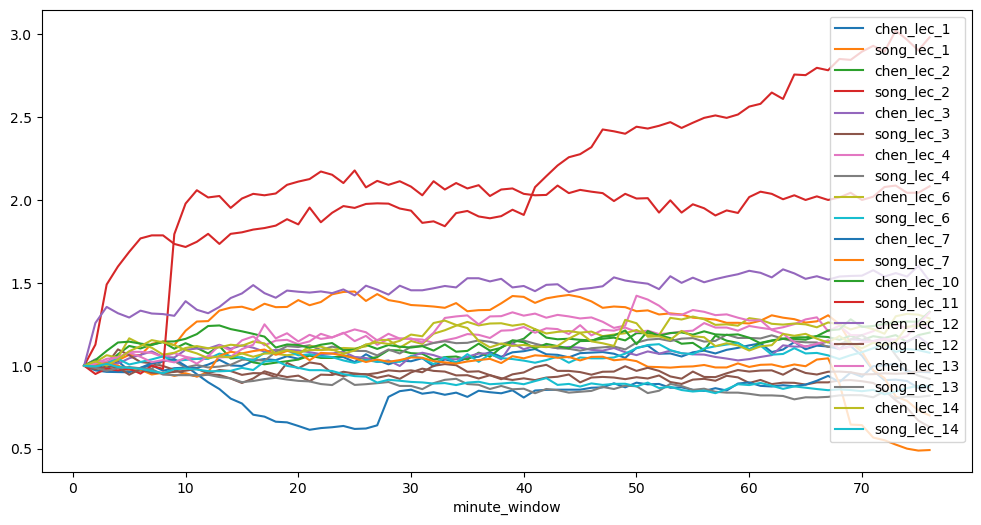

In [44]:
import tensorflow as tf

# First, we need to normalize our data to ensure that the model trains effectively
normalized = co2_data.div(co2_data.iloc[0])
normalized.plot(figsize=(12, 6))


In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Assume `X` is your normalized dataset with shape (75, number_of_lectures)
# Each column represents a lecture's CO2 readings over the 75 minutes
# Each row represents a minute in all lectures
X = normalized.copy()

# Sequentially split the data into training, validation, and testing sets based on lectures
num_lectures = X.shape[1]
train_lectures = int(num_lectures * 0.6)  # 60% for training
valid_lectures = int(num_lectures * 0.2)  # 20% for validation
test_lectures = num_lectures - train_lectures - valid_lectures  # Remaining for testing

X_train, X_valid, X_test = np.split(X.values, [train_lectures, train_lectures + valid_lectures], axis=1)

# Define the model
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[0],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(X_train.shape[0]))  # Output layer has the same number of neurons as the input

model.compile(optimizer='adam', loss='mse')

# Reshape data for the model (batch_size, timesteps, features)
X_train_reshaped = X_train.T.reshape(X_train.shape[1], X_train.shape[0], 1)
X_valid_reshaped = X_valid.T.reshape(X_valid.shape[1], X_valid.shape[0], 1)
X_test_reshaped = X_test.T.reshape(X_test.shape[1], X_test.shape[0], 1)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_reshaped, X_train.T, epochs=500, validation_data=(X_valid_reshaped, X_valid.T), callbacks=[early_stopping])

# Predict on the test data
test_predictions = model.predict(X_test_reshaped)

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(X_test.T, test_predictions)
mse = mean_squared_error(X_test.T, test_predictions)
r2 = r2_score(X_test.T, test_predictions)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")




Epoch 1/500


1/1 [==============================] - 0s 411ms/step - loss: 1.4858 - val_loss: 1.9716
Epoch 2/500
1/1 [==============================] - 0s 21ms/step - loss: 1.4176 - val_loss: 1.8983
Epoch 3/500
1/1 [==============================] - 0s 21ms/step - loss: 1.3613 - val_loss: 1.8370
Epoch 4/500
1/1 [==============================] - 0s 21ms/step - loss: 1.3150 - val_loss: 1.7822
Epoch 5/500
1/1 [==============================] - 0s 20ms/step - loss: 1.2748 - val_loss: 1.7310
Epoch 6/500
1/1 [==============================] - 0s 23ms/step - loss: 1.2380 - val_loss: 1.6834
Epoch 7/500
1/1 [==============================] - 0s 21ms/step - loss: 1.2041 - val_loss: 1.6392
Epoch 8/500
1/1 [==============================] - 0s 22ms/step - loss: 1.1727 - val_loss: 1.5974
Epoch 9/500
1/1 [==============================] - 0s 20ms/step - loss: 1.1429 - val_loss: 1.5574
Epoch 10/500
1/1 [==============================] - 0s 19ms/step - loss: 1.1144 - val_loss: 1.5184
Epoch 11/500
1/1 [============

This is not working. Time for a new approach.

## train-validate-test sliced_dataframes

In the context of time series data, especially when you have distinct windows or frames like your lecture recordings, you would typically split these frames into training, validation, and test sets. This approach ensures that the temporal integrity of the data is maintained, and the model learns from entire frames rather than fragmented pieces of them.

For example, if you have 16 lectures (frames), you might use 12 for training, 2 for validation, and 2 for testing. This way, each set contains complete lecture frames, and the model can learn and be evaluated on the full context of each lecture.

This is similar to handling images in machine learning, where each image is treated as a whole unit (a grid of pixels) during training and evaluation. Just as you wouldn't want to train a model on half an image, you wouldn't want to train a time series model on partial frames when each frame represents a coherent sequence of data.

In your case, since each lecture is a separate sequence, you'd want to ensure that each sequence (lecture) is used entirely for training, validation, or testing, rather than splitting individual sequences across different sets.

In [47]:
from sklearn.model_selection import train_test_split

# Set a seed for reproducibility
np.random.seed(42)

# Get a list of all lecture keys
lecture_keys = list(sliced_dataframes.keys())

# Randomly split the lecture keys into training, validation, and test sets
train_keys, test_keys = train_test_split(lecture_keys, test_size=0.25)  # Split into train and test first
train_keys, val_keys = train_test_split(train_keys, test_size=0.2)  # Split train into train and validation

# Create dictionaries to hold the training, validation, and test frames
train_frames = {key: sliced_dataframes[key] for key in train_keys}
val_frames = {key: sliced_dataframes[key] for key in val_keys}
test_frames = {key: sliced_dataframes[key] for key in test_keys}

# Print out the keys for each set to verify the split
print("Training keys:", train_keys)
print("Validation keys:", val_keys)
print("Test keys:", test_keys)

Training keys: ['chen_lec_14', 'chen_lec_4', 'chen_lec_2', 'song_lec_2', 'chen_lec_12', 'song_lec_14', 'song_lec_11', 'chen_lec_3', 'song_lec_3', 'chen_lec_13', 'song_lec_4', 'song_lec_7']
Validation keys: ['song_lec_6', 'chen_lec_7', 'chen_lec_10']
Test keys: ['chen_lec_1', 'song_lec_13', 'song_lec_12', 'song_lec_1', 'chen_lec_6']


In [51]:
chen_lec_1_df = sliced_dataframes['chen_lec_1']
chen_lec_1_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76 entries, 2024-03-14 08:00:00 to 2024-03-14 09:15:00
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Carbon dioxide(ppm)        76 non-null     float64
 1   Temperature(°F)            76 non-null     float64
 2   Relative humidity(%)       76 non-null     float64
 3   Atmospheric pressure(hPa)  76 non-null     float64
 4   door1                      76 non-null     object 
 5   door2                      76 non-null     object 
 6   hvac                       76 non-null     object 
 7   subject_count              76 non-null     float64
 8   hour                       76 non-null     int64  
 9   minute                     76 non-null     int64  
 10  day_of_week                76 non-null     int64  
 11  weekday                    76 non-null     object 
 12  song_lec                   76 non-null     bool   
 13  chen_lec      

To use each of these data frames as a neuron or to apply methods similar to those used for images, you can consider the following approaches:

1. **Feature Extraction**: Instead of using the raw time series data, you can extract meaningful features from each lecture, such as the mean, standard deviation, minimum, maximum, and other statistical features of the measurements. These features can then be used as inputs to your neural network, with each lecture providing a set of features.

2. **Flattening**: You can flatten the time series data from each lecture into a long vector and use these vectors as inputs to your neural network. This is similar to how images are flattened into long vectors when using fully connected layers. However, this approach might lose the temporal structure of the data.

3. **Convolutional Neural Networks (CNNs)**: You can treat each lecture's time series data as a one-dimensional "image" and apply 1D convolutional layers to extract features. This approach can capture the local patterns in the time series data, similar to how 2D CNNs capture patterns in images.

4. **Recurrent Neural Networks (RNNs)**: Given the temporal nature of the data, RNNs or their variants like Long Short-Term Memory (LSTM) networks or Gated Recurrent Units (GRUs) can be used to model the sequential dependencies in the time series data. Each lecture's time series data can be fed into an RNN as a sequence.

5. **Combining Approaches**: You can also combine these approaches. For example, you can use CNNs to extract local features from each lecture's time series data and then feed these features into an RNN to capture the temporal dependencies.

Based on the structure of your data and the specific problem you're trying to solve, you can choose one or a combination of these approaches to build your neural network. It's essential to experiment with different architectures and hyperparameters to find the best model for your data.

## Multivariate Example
1. copy sliced_dataframes by subsetting the columns in each dataframe to `Carbon dioxide(ppm)`, `door1`, `door2` to a new dictionary called model_set
2. normalize `Carbon dioxide(ppm)` and use get_dummies on `door1` and `door`
3. Create Sequences: Use a sliding window approach to create sequences from each lecture's data. Each sequence will contain a certain number of timesteps, and each timestep will include all the selected and processed features.
    - so the sequence length should be the number of selected features?

In [48]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# 1. Copy sliced_dataframes by subsetting the columns
model_set = {key: df[['Carbon dioxide(ppm)', 'door1', 'door2','hvac']].copy() for key, df in sliced_dataframes.items()}

# 2. Normalize and encode features
scaler = MinMaxScaler()

# Normalize 'Carbon dioxide(ppm)' column
for df in model_set.values():
    df['Carbon dioxide(ppm)'] = scaler.fit_transform(df[['Carbon dioxide(ppm)']])

# Encode 'door1' and 'door2' columns
for df in model_set.values():
    df['door1'] = df['door1'].map({'open': 1, 'closed': 0})
    df['door2'] = df['door2'].map({'open': 1, 'closed': 0})
    df['hvac'] = df['hvac'].map({'on': 1, 'off': 0})

# Check the data types and shapes after normalization and encoding
for key, df in model_set.items():
    print(f"{key}: {df.shape}")
    print(df.dtypes)


chen_lec_1: (76, 4)
Carbon dioxide(ppm)    float64
door1                    int64
door2                    int64
hvac                     int64
dtype: object
song_lec_1: (76, 4)
Carbon dioxide(ppm)    float64
door1                    int64
door2                    int64
hvac                     int64
dtype: object
chen_lec_2: (76, 4)
Carbon dioxide(ppm)    float64
door1                    int64
door2                    int64
hvac                     int64
dtype: object
song_lec_2: (76, 4)
Carbon dioxide(ppm)    float64
door1                    int64
door2                    int64
hvac                     int64
dtype: object
chen_lec_3: (76, 4)
Carbon dioxide(ppm)    float64
door1                    int64
door2                    int64
hvac                     int64
dtype: object
song_lec_3: (76, 4)
Carbon dioxide(ppm)    float64
door1                    int64
door2                    int64
hvac                     int64
dtype: object
chen_lec_4: (76, 4)
Carbon dioxide(ppm)    float64
d

For step 3, Creating Sequences:

The sequence length should be the number of timesteps you want to look back. This is not necessarily the same as the number of features. For example, if you want to use the last 10 minutes of data to predict the next minute, your sequence length would be 10.
Each sequence will contain multiple features for each timestep. In this case, each timestep will include the normalized Carbon dioxide(ppm) value and the encoded door1 and door2 values.
Here's an example of how you might create sequences:

In [60]:
sequence_length = 15  # Number of timesteps to look back
sequences = []

for df in model_set.values():
    for i in range(len(df) - sequence_length):
        sequence = df.iloc[i:i + sequence_length].values  # Extract the sequence
        sequences.append(sequence)


In [61]:
sequences

[array([[0.48484848],
        [0.4969697 ],
        [0.41818182],
        [0.58181818],
        [0.37575758],
        [0.43636364],
        [0.49090909],
        [0.37575758],
        [0.43030303],
        [0.44242424],
        [0.43636364],
        [0.50909091],
        [0.61212121],
        [0.49090909],
        [0.47878788]]),
 array([[0.4969697 ],
        [0.41818182],
        [0.58181818],
        [0.37575758],
        [0.43636364],
        [0.49090909],
        [0.37575758],
        [0.43030303],
        [0.44242424],
        [0.43636364],
        [0.50909091],
        [0.61212121],
        [0.49090909],
        [0.47878788],
        [0.58787879]]),
 array([[0.41818182],
        [0.58181818],
        [0.37575758],
        [0.43636364],
        [0.49090909],
        [0.37575758],
        [0.43030303],
        [0.44242424],
        [0.43636364],
        [0.50909091],
        [0.61212121],
        [0.49090909],
        [0.47878788],
        [0.58787879],
        [0.63030303]]),
 arr

In [49]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split

sequence_length = 15 # Number of timesteps to look back
sequences = []

# Create sequences for each lecture
for df in model_set.values():
    # Ensure all sequences have the same number of features
    if df.shape[1] != 4:
        print("DataFrame with incorrect number of features found")
        continue

    for i in range(len(df) - sequence_length + 1):
        sequence = df.iloc[i:i + sequence_length].values  # Extract the sequence
        
        # Check for NaN values in the sequence
        if np.isnan(sequence).any():
            print("NaN values found in sequence, skipping")
            continue
        
        sequences.append(sequence)

# Convert to numpy array
sequences = np.array(sequences)

# Continue with the rest of your code...


# 2. Split data
X = sequences[:, :-1, :]  # Features: all but the last timestep
y = sequences[:, -1, 0]   # Labels: 'Carbon dioxide(ppm)' of the last timestep

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3. Build the RNN model
model = Sequential([
    SimpleRNN(32, input_shape=(sequence_length - 1, 4)),  # 3 features: 'Carbon dioxide(ppm)', 'door1', 'door2'
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 4. Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

# 5. Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions on validation set
y_val_pred = model.predict(X_val)

# Validation metrics
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation MAE: {val_mae}')
print(f'Validation RMSE: {val_rmse}')
print(f'Validation R-squared: {val_r2}')

# Predictions on test set
y_test_pred = model.predict(X_test)

# Test metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test MAE: {test_mae}')
print(f'Test RMSE: {test_rmse}')
print(f'Test R-squared: {test_r2}')


Epoch 1/100
28/28 [==============================] - 1s 6ms/step - loss: 0.0680 - val_loss: 0.0239
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0175
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0170
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0192 - val_loss: 0.0156
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0180 - val_loss: 0.0143
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0168 - val_loss: 0.0147
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0166 - val_loss: 0.0132
Epoch 8/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0156 - val_loss: 0.0121
Epoch 9/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0117
Epoch 10/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0145 - val_loss: 0.0108
Epoch 11/

The above should forecast 1 minute into the future. Let's try forecasting the next 5 minutes.

In [125]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sequence_length = 15  # Number of timesteps to look back
sequences = []

# Create sequences for each lecture
for key, df in model_set.items():
    print(f"{key}: {df.shape}")  # Print the shape of each dataframe

    # Ensure all sequences have the same number of features
    if df.shape[1] != 4:
        print(f"DataFrame {key} with incorrect number of features found")
        continue

    for i in range(len(df) - sequence_length + 1):
        sequence = df.iloc[i:i + sequence_length].values  # Extract the sequence
        
        # Check for NaN values in the sequence
        if np.isnan(sequence).any():
            print(f"NaN values found in sequence of {key}, skipping")
            continue
        
        sequences.append(sequence)


# Convert to numpy array
sequences = np.array(sequences)

# 2. Split data
X = sequences[:, :-1, :]  # Features: all but the last timestep
y = sequences[:, -1, 0]   # Labels: 'Carbon dioxide(ppm)' of the last timestep

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3. Build the RNN model
model = Sequential([
    SimpleRNN(32, input_shape=(sequence_length - 1, 4)),  # 3 features: 'Carbon dioxide(ppm)', 'door1', 'door2'
    Dense(1, activation='relu'),
])

model.compile(optimizer='adam', loss='mse')

# 4. Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

# 5. Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')

# Predictions on validation set
y_val_pred = model.predict(X_val)

# Validation metrics
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation MAE: {val_mae}')
print(f'Validation RMSE: {val_rmse}')
print(f'Validation R-squared: {val_r2}')

# Predictions on test set
y_test_pred = model.predict(X_test)

# Test metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test MAE: {test_mae}')
print(f'Test RMSE: {test_rmse}')
print(f'Test R-squared: {test_r2}')



chen_lec_1: (76, 4)
song_lec_1: (76, 4)
chen_lec_2: (76, 4)
song_lec_2: (76, 4)
chen_lec_3: (76, 4)
song_lec_3: (76, 4)
chen_lec_4: (76, 4)
song_lec_4: (76, 4)
chen_lec_6: (76, 4)
song_lec_6: (76, 4)
chen_lec_7: (76, 4)
song_lec_7: (76, 4)
chen_lec_10: (76, 4)
song_lec_11: (76, 4)
chen_lec_12: (76, 4)
song_lec_12: (76, 4)
Epoch 1/100


22/22 [==============================] - 1s 8ms/step - loss: 0.2653 - val_loss: 0.0784
Epoch 2/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0300
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0167
Epoch 4/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0175 - val_loss: 0.0147
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0156 - val_loss: 0.0132
Epoch 6/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.0119
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0113
Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0120
Epoch 9/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0109
Epoch 10/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0108
Epoch 11/100
22/22 [=

In [50]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sequence_length = 35  # Number of timesteps to look back
prediction_length = 5  # Number of timesteps to predict
sequences = []

# Create sequences for each lecture
for key, df in model_set.items():
    print(f"{key}: {df.shape}")  # Print the shape of each dataframe

    # Ensure all sequences have the same number of features
    if df.shape[1] != 4:
        print(f"DataFrame {key} with incorrect number of features found")
        continue

    for i in range(len(df) - sequence_length - prediction_length + 2):
        sequence = df.iloc[i:i + sequence_length + prediction_length - 1].values  # Extract the sequence
        
        # Check for NaN values in the sequence
        if np.isnan(sequence).any():
            print(f"NaN values found in sequence of {key}, skipping")
            continue
        
        sequences.append(sequence)

# Convert to numpy array
sequences = np.array(sequences)

# 2. Split data
X = sequences[:, :-prediction_length, :]  # Features: all but the last 'prediction_length' timesteps
y = sequences[:, -prediction_length:, 0]   # Labels: 'Carbon dioxide(ppm)' of the last 'prediction_length' timesteps

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Set a seed for reproducibility
tf.random.set_seed(42)


# 3. Build the RNN model
model = Sequential([
    SimpleRNN(32, input_shape=(sequence_length - 1, 4)),  # 3 features: 'Carbon dioxide(ppm)', 'door1', 'door2'
    Dense(prediction_length),
])

early_stopping = EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])

# 4. Train the model
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), callbacks=[early_stopping])

# 5. Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')

# Predictions on validation set
y_val_pred = model.predict(X_val)

# Validation metrics
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation MAE: {val_mae}')
print(f'Validation RMSE: {val_rmse}')
print(f'Validation R-squared: {val_r2}')

# Predictions on test set
y_test_pred = model.predict(X_test)

# Test metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test MAE: {test_mae}')
print(f'Test RMSE: {test_rmse}')
print(f'Test R-squared: {test_r2}')


chen_lec_1: (76, 4)
song_lec_1: (76, 4)
chen_lec_2: (76, 4)
song_lec_2: (76, 4)
chen_lec_3: (76, 4)
song_lec_3: (76, 4)
chen_lec_4: (76, 4)
song_lec_4: (76, 4)
chen_lec_6: (76, 4)
song_lec_6: (76, 4)
chen_lec_7: (76, 4)
song_lec_7: (76, 4)
chen_lec_10: (76, 4)
song_lec_11: (76, 4)
chen_lec_12: (76, 4)
song_lec_12: (76, 4)
chen_lec_13: (76, 4)
song_lec_13: (76, 4)
chen_lec_14: (76, 4)
song_lec_14: (76, 4)
Epoch 1/500

17/17 [==============================] - 1s 12ms/step - loss: 0.1400 - mae: 0.4151 - val_loss: 0.0562 - val_mae: 0.2640
Epoch 2/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0397 - mae: 0.2268 - val_loss: 0.0295 - val_mae: 0.1954
Epoch 3/500
17/17 [==============================] - 0s 3ms/step - loss: 0.0259 - mae: 0.1803 - val_loss: 0.0243 - val_mae: 0.1678
Epoch 4/500
17/17 [==============================] - 0s 3ms/step - loss: 0.0209 - mae: 0.1615 - val_loss: 0.0199 - val_mae: 0.1555
Epoch 5/500
17/17 [==============================] - 0s 4ms/step -

1/1 [==============================] - 0s 14ms/step


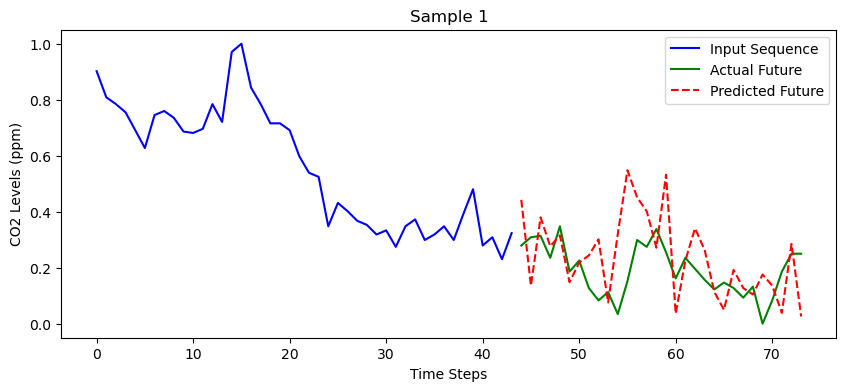

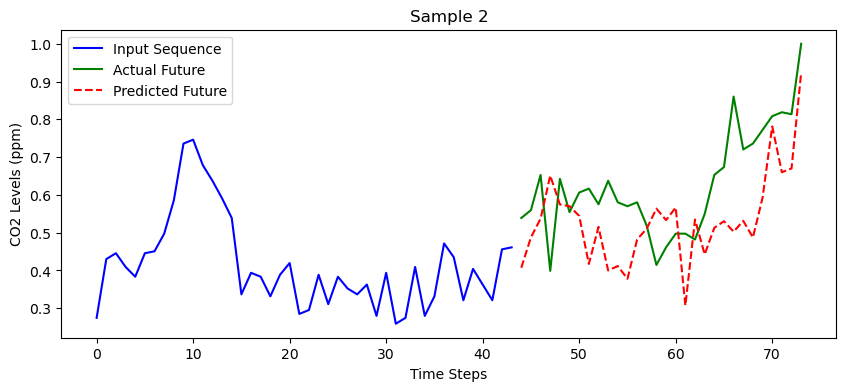

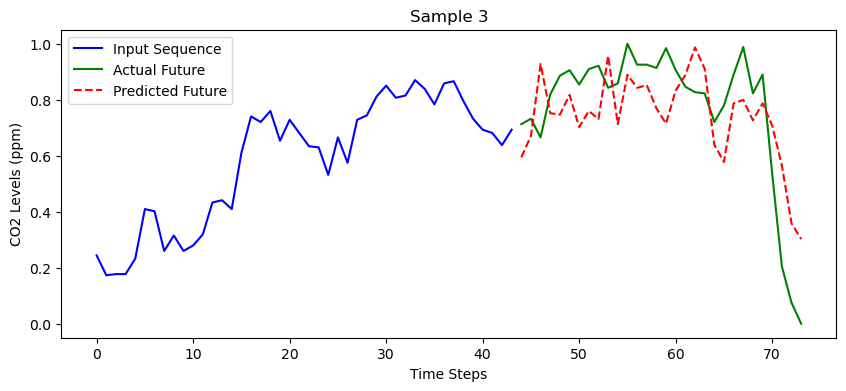

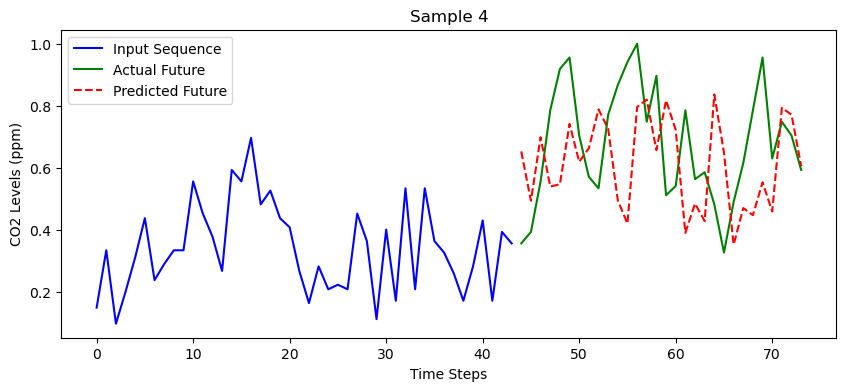

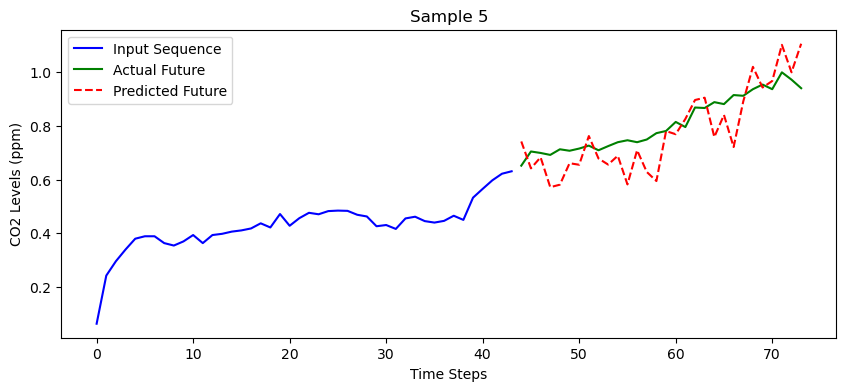

In [58]:
import matplotlib.pyplot as plt

# Select a sample of sequences from the test set
sample_indices = np.random.choice(X_test.shape[0], 5, replace=False)
sample_sequences = X_test[sample_indices]
sample_labels = y_test[sample_indices]

# Get predictions for the selected samples
sample_predictions = model.predict(sample_sequences)

# Plot the actual vs predicted CO2 levels for the selected samples
for i in range(len(sample_indices)):
    plt.figure(figsize=(10, 4))
    plt.plot(range(sequence_length - 1), sample_sequences[i, :, 0], 'b-', label='Input Sequence')
    plt.plot(range(sequence_length - 1, sequence_length - 1 + prediction_length), sample_labels[i], 'g-', label='Actual Future')
    plt.plot(range(sequence_length - 1, sequence_length - 1 + prediction_length), sample_predictions[i], 'r--', label='Predicted Future')
    plt.xlabel('Time Steps')
    plt.ylabel('CO2 Levels (ppm)')
    plt.title(f'Sample {i + 1}')
    plt.legend()
    plt.show()


## Larger RNN

In [60]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Copy sliced_dataframes by subsetting the columns
model_set = {key: df[['Carbon dioxide(ppm)', 'door1', 'door2', 'hvac']].copy() for key, df in sliced_dataframes.items()}

# 2. Normalize 'Carbon dioxide(ppm)' and encode 'door1', 'door2', and 'hvac'
scaler = MinMaxScaler()

for key, df in model_set.items():
    # Normalize 'Carbon dioxide(ppm)'
    # Calculate the one-minute difference ('diff') and one-minute lag ('lag') for 'Carbon dioxide(ppm)'
    df['diff'] = df['Carbon dioxide(ppm)'].diff()
    df['diff'] = scaler.fit_transform(df[['diff']])
    df['Carbon dioxide(ppm)'] = scaler.fit_transform(df[['Carbon dioxide(ppm)']])

    # Encode 'door1', 'door2', and 'hvac'
    df['door1'] = df['door1'].map({'open': 1, 'closed': 0})
    df['door2'] = df['door2'].map({'open': 1, 'closed': 0})
    df['hvac'] = df['hvac'].map({'on': 1, 'off': 0})

    # Calculate the one-minute difference ('diff') and one-minute lag ('lag') for 'Carbon dioxide(ppm)'
    # df['diff'] = df['Carbon dioxide(ppm)'].diff()
    df['lag'] = df['Carbon dioxide(ppm)'].shift()

    # Drop NA values that result from diff and lag calculations
    df.dropna(inplace=True)

    # Check the data types and shapes after normalization, encoding, and feature creation
    print(f"{key}: {df.shape}")
    print(df.dtypes)


chen_lec_1: (75, 6)
Carbon dioxide(ppm)    float64
door1                    int64
door2                    int64
hvac                     int64
diff                   float64
lag                    float64
dtype: object
song_lec_1: (75, 6)
Carbon dioxide(ppm)    float64
door1                    int64
door2                    int64
hvac                     int64
diff                   float64
lag                    float64
dtype: object
chen_lec_2: (75, 6)
Carbon dioxide(ppm)    float64
door1                    int64
door2                    int64
hvac                     int64
diff                   float64
lag                    float64
dtype: object
song_lec_2: (75, 6)
Carbon dioxide(ppm)    float64
door1                    int64
door2                    int64
hvac                     int64
diff                   float64
lag                    float64
dtype: object
chen_lec_3: (75, 6)
Carbon dioxide(ppm)    float64
door1                    int64
door2                    int64
hvac   

In [76]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sequence_length = 30  # Number of timesteps to look back
prediction_length = 7  # Number of timesteps to predict
sequences = []

# Create sequences for each lecture
for key, df in model_set.items():
    print(f"{key}: {df.shape}")  # Print the shape of each dataframe

    # Ensure all sequences have the same number of features
    if df.shape[1] != 6:
        print(f"DataFrame {key} with incorrect number of features found")
        continue

    for i in range(len(df) - sequence_length - prediction_length + 2):
        sequence = df.iloc[i:i + sequence_length + prediction_length - 1].values  # Extract the sequence
        
        # Check for NaN values in the sequence
        if np.isnan(sequence).any():
            print(f"NaN values found in sequence of {key}, skipping")
            continue
        
        sequences.append(sequence)

# Convert to numpy array
sequences = np.array(sequences)

# 2. Split data
X = sequences[:, :-prediction_length, :]  # Features: all but the last 'prediction_length' timesteps
y = sequences[:, -prediction_length:, 0]   # Labels: 'Carbon dioxide(ppm)' of the last 'prediction_length' timesteps

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Set a seed for reproducibility
tf.random.set_seed(42)


# 3. Build the RNN model
model = Sequential([
    LSTM(128, input_shape=(sequence_length - 1, 6)),  # 3 features: 'Carbon dioxide(ppm)', 'door1', 'door2', 'hvac', 'diff', 'lag'
    Dense(prediction_length),
])

early_stopping = EarlyStopping(monitor='val_mae', patience=40, restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.8)

model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])

# 4. Train the model
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), callbacks=[early_stopping])

# 5. Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')

# Predictions on validation set
y_val_pred = model.predict(X_val)

# Validation metrics
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation MAE: {val_mae}')
print(f'Validation RMSE: {val_rmse}')
print(f'Validation R-squared: {val_r2}')

# Predictions on test set
y_test_pred = model.predict(X_test)

# Test metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test MAE: {test_mae}')
print(f'Test RMSE: {test_rmse}')
print(f'Test R-squared: {test_r2}')

chen_lec_1: (75, 6)
song_lec_1: (75, 6)
chen_lec_2: (75, 6)
song_lec_2: (75, 6)
chen_lec_3: (75, 6)
song_lec_3: (75, 6)
chen_lec_4: (75, 6)
song_lec_4: (75, 6)
chen_lec_6: (75, 6)
song_lec_6: (75, 6)
chen_lec_7: (75, 6)
song_lec_7: (75, 6)
chen_lec_10: (75, 6)
song_lec_11: (75, 6)
chen_lec_12: (75, 6)
song_lec_12: (75, 6)
chen_lec_13: (75, 6)
song_lec_13: (75, 6)
chen_lec_14: (75, 6)
song_lec_14: (75, 6)
Epoch 1/500
18/18 [==============================] - 1s 26ms/step - loss: 0.2365 - mae: 0.5481 - val_loss: 0.2568 - val_mae: 0.5571
Epoch 2/500
18/18 [==============================] - 0s 9ms/step - loss: 0.1961 - mae: 0.4811 - val_loss: 0.2427 - val_mae: 0.5322
Epoch 3/500
18/18 [==============================] - 0s 9ms/step - loss: 0.1888 - mae: 0.4653 - val_loss: 0.2356 - val_mae: 0.5189
Epoch 4/500
18/18 [==============================] - 0s 9ms/step - loss: 0.1844 - mae: 0.4571 - val_loss: 0.2301 - val_mae: 0.5067
Epoch 5/500
18/18 [==============================] - 0s 9ms/step - 

In [72]:
X.shape, y.shape

((940, 14, 6), (940, 15))

In [77]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sequence_length = 30  # Number of timesteps to look back
prediction_length = 7  # Number of timesteps to predict
sequences = []

# Create sequences for each lecture
for key, df in model_set.items():
    print(f"{key}: {df.shape}")  # Print the shape of each dataframe

    # Ensure all sequences have the same number of features
    if df.shape[1] != 6:
        print(f"DataFrame {key} with incorrect number of features found")
        continue

    for i in range(len(df) - sequence_length - prediction_length + 2):
        sequence = df.iloc[i:i + sequence_length + prediction_length - 1].values  # Extract the sequence
        
        # Check for NaN values in the sequence
        if np.isnan(sequence).any():
            print(f"NaN values found in sequence of {key}, skipping")
            continue
        
        sequences.append(sequence)

# Convert to numpy array
sequences = np.array(sequences)

# 2. Split data
X = sequences[:, :-prediction_length, :]  # Features: all but the last 'prediction_length' timesteps
y = sequences[:, -prediction_length:, 0]   # Labels: 'Carbon dioxide(ppm)' of the last 'prediction_length' timesteps

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Set a seed for reproducibility
tf.random.set_seed(42)


# 3. Build the RNN model
model = Sequential([
    SimpleRNN(128, input_shape=(sequence_length - 1, 6)),  # 3 features: 'Carbon dioxide(ppm)', 'door1', 'door2', 'hvac', 'diff', 'lag'
    Dense(prediction_length),
])

early_stopping = EarlyStopping(monitor='val_mae', patience=40, restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.8)

model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])

# 4. Train the model
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), callbacks=[early_stopping])

# 5. Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')

# Predictions on validation set
y_val_pred = model.predict(X_val)

# Validation metrics
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation MAE: {val_mae}')
print(f'Validation RMSE: {val_rmse}')
print(f'Validation R-squared: {val_r2}')

# Predictions on test set
y_test_pred = model.predict(X_test)

# Test metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test MAE: {test_mae}')
print(f'Test RMSE: {test_rmse}')
print(f'Test R-squared: {test_r2}')

chen_lec_1: (75, 6)
song_lec_1: (75, 6)
chen_lec_2: (75, 6)
song_lec_2: (75, 6)
chen_lec_3: (75, 6)
song_lec_3: (75, 6)
chen_lec_4: (75, 6)
song_lec_4: (75, 6)
chen_lec_6: (75, 6)
song_lec_6: (75, 6)
chen_lec_7: (75, 6)
song_lec_7: (75, 6)
chen_lec_10: (75, 6)
song_lec_11: (75, 6)
chen_lec_12: (75, 6)
song_lec_12: (75, 6)
chen_lec_13: (75, 6)
song_lec_13: (75, 6)
chen_lec_14: (75, 6)
song_lec_14: (75, 6)
Epoch 1/500
18/18 [==============================] - 1s 12ms/step - loss: 0.2555 - mae: 0.5667 - val_loss: 0.2388 - val_mae: 0.5389
Epoch 2/500
18/18 [==============================] - 0s 4ms/step - loss: 0.1813 - mae: 0.4620 - val_loss: 0.2216 - val_mae: 0.5096
Epoch 3/500
18/18 [==============================] - 0s 4ms/step - loss: 0.1684 - mae: 0.4403 - val_loss: 0.2228 - val_mae: 0.5081
Epoch 4/500
18/18 [==============================] - 0s 4ms/step - loss: 0.1655 - mae: 0.4298 - val_loss: 0.2218 - val_mae: 0.5168
Epoch 5/500
18/18 [==============================] - 0s 4ms/step - 